In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, LSTM, Dense, Dropout, BatchNormalization, Masking, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

In [2]:
df_transactions = pd.read_json('data/transactions.json', lines=True)
df_users = pd.read_csv('data/users.csv')
df_merchants = pd.read_csv('data/merchants.csv')

In [3]:
df_merged = pd.merge(df_transactions, df_users, on='user_id', how='left')

# Then, join the result with df_merchants on merchant_id
df_merged = pd.merge(df_merged, df_merchants, on='merchant_id', how='left')

df = df_merged

In [4]:
categorical_cols = [
    'channel', 'currency', 'device', 'payment_method', 'category',
    'country_x', 'country_y', 'sex', 'education', 'primary_source_of_income'
]

binary_cols = [
    'is_international', 'is_first_time_merchant', 'has_fraud_history'
]

numerical_cols = [
    'amount', 'session_length_seconds', 'age', 'risk_score', 'trust_score',
    'number_of_alerts_last_6_months', 'avg_transaction_amount',
    'account_age_months', 'sum_of_monthly_expenses', 'sum_of_monthly_installments'
]

In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

# Temporal features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['days_since_signup'] = (df['timestamp'] - df['signup_date']).dt.total_seconds() / (3600 * 24)

numerical_cols += ['hour', 'day_of_week', 'days_since_signup']

# Location
df['lat'] = df['location'].apply(lambda x: x['lat'] if isinstance(x, dict) else np.nan)
df['long'] = df['location'].apply(lambda x: x['long'] if isinstance(x, dict) else np.nan)

numerical_cols += ['lat', 'long']

In [6]:
# Process categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Process binary variables
for col in binary_cols:
    df[col] = df[col].astype(int)

# Normalize numerical features
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 35 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   transaction_id                  500000 non-null  object        
 1   timestamp                       500000 non-null  datetime64[ns]
 2   user_id                         500000 non-null  object        
 3   merchant_id                     500000 non-null  object        
 4   amount                          500000 non-null  float64       
 5   channel                         500000 non-null  int32         
 6   currency                        500000 non-null  int32         
 7   device                          500000 non-null  int32         
 8   location                        500000 non-null  object        
 9   payment_method                  500000 non-null  int32         
 10  is_international                500000 non-null  int32  

In [8]:
# Create Transaction-Count-Based Sequences
target_column = 'is_fraud'
user_column = 'user_id'
sequence_length = 7    # Last 7 transactions to consider
padding_value = 0  

data_sequences = []
labels = []
sequence_indices = []  # To track which rows correspond to which sequences

# Group by user
grouped = df.groupby(user_column)

for user_id, user_data in grouped:
    # Sort by timestamp to ensure chronological order
    user_data = user_data.sort_values(by='timestamp')
    
    # Convert to numpy arrays
    user_data_values = user_data[numerical_cols].values
    
    for i in range(len(user_data)):
        # Get indices of previous transactions (up to sequence_length-1)
        start_idx = max(0, i - (sequence_length - 1))
        window_indices = range(start_idx, i + 1)
        
        # Get the sequence of transactions
        window_data = user_data_values[window_indices]
        
        # Pad if fewer than sequence_length transactions
        if len(window_data) < sequence_length:
            pad_length = sequence_length - len(window_data)
            padding = np.full((pad_length, len(numerical_cols)), padding_value)
            window_data = np.vstack([padding, window_data])
        
        data_sequences.append(window_data)
        labels.append(user_data[target_column].iloc[i])
        sequence_indices.append(user_data.index[i])  # Store the original index

# Convert to numpy arrays
data_sequences = np.array(data_sequences)
labels = np.array(labels)

In [9]:
# Create DataFrame index to position mapping
index_to_pos = {idx: pos for pos, idx in enumerate(df.index)}

# Get the positions of the last transaction in each sequence
seq_positions = [index_to_pos[idx] for idx in sequence_indices]

# Split into train and test sets (80-20 split)
(X_seq_train, X_seq_test, 
 seq_pos_train, seq_pos_test,
 y_train, y_test) = train_test_split(
    data_sequences,
    seq_positions,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# Prepare input dictionaries
def create_input_dict(sequences, positions, df):
    inputs = {'numerical_seq': sequences}
    
    # Add categorical inputs
    for col in categorical_cols:
        inputs[f'{col}_input'] = df.iloc[positions][col].values.reshape(-1, 1)
    
    # Add binary features
    inputs['binary_features'] = df.iloc[positions][binary_cols].values
    
    return inputs

train_data = create_input_dict(X_seq_train, seq_pos_train, df)
test_data = create_input_dict(X_seq_test, seq_pos_test, df)

In [10]:
data_sequences[50]

array([[0.15200179, 0.58376068, 0.32142857, 0.70526752, 0.74341756,
        0.33333333, 0.21143429, 0.72566372, 0.06710029, 0.00997887,
        0.47826087, 0.        , 0.9503339 , 0.83085   , 0.3174316 ],
       [0.05368883, 0.00769231, 0.32142857, 0.70526752, 0.71455741,
        0.44444444, 0.17908932, 0.00884956, 0.06710029, 0.00997887,
        0.60869565, 0.16666667, 0.9535385 , 0.5574014 , 0.38291714],
       [0.18435778, 0.95897436, 0.32142857, 0.70526752, 0.46788036,
        0.33333333, 0.06612876, 0.28318584, 0.06710029, 0.00997887,
        1.        , 0.33333333, 0.95408177, 0.47482743, 0.21379379],
       [0.0215147 , 0.0965812 , 0.32142857, 0.70526752, 0.81277443,
        0.22222222, 0.18553574, 0.77876106, 0.06710029, 0.00997887,
        0.60869565, 0.16666667, 0.95908425, 0.19233424, 0.42584469],
       [0.04758974, 0.99487179, 0.32142857, 0.70526752, 0.8272213 ,
        0.22222222, 0.04265644, 0.79646018, 0.06710029, 0.00997887,
        0.69565217, 0.33333333, 0.96228582, 

In [12]:
from tensorflow.keras.models import load_model

In [12]:
# Analyze categorical feature cardinalities
categorical_cardinalities = {col: df[col].nunique() for col in categorical_cols}
embedding_dims = {
    col: min(50, max(2, card // 2 + 1)) 
    for col, card in categorical_cardinalities.items()
}

In [21]:
def create_deep_rnn_model(sequence_length, numerical_cols, categorical_cols, binary_cols, 
                         categorical_cardinalities, embedding_dims):
    # Numerical sequence input (Deep LSTM path)
    numerical_input = Input(shape=(sequence_length, len(numerical_cols)), name='numerical_seq')
    
    # Deep LSTM layers (3 layers)
    

    masked_input = Masking(mask_value=0.0)(numerical_input)
    
    lstm_layer1 = LSTM(128, return_sequences=True, name='LSTM_1')(masked_input)
    lstm_layer1 = LayerNormalization()(lstm_layer1)
    
    lstm_layer2 = LSTM(128, return_sequences=True, name='LSTM_2')(lstm_layer1)
    lstm_layer2 = LayerNormalization()(lstm_layer2)
    
    lstm_layer3 = LSTM(128, name='LSTM_3')(lstm_layer2)
    lstm_layer3 = LayerNormalization()(lstm_layer3)

    
    # Entity embeddings for categorical features
    categorical_inputs = []
    categorical_embeddings = []
    
    for col in categorical_cols:
        input_layer = Input(shape=(1,), name=f'{col}_input')
        categorical_inputs.append(input_layer)
        
        embedding = Embedding(
            input_dim=categorical_cardinalities[col] + 1,
            output_dim=embedding_dims[col],
            name=f'{col}_embedding',
            embeddings_regularizer=l2(1e-4)
        )(input_layer)
        
        flattened = Flatten()(embedding)
        flattened = Dropout(0.1)(flattened)
        categorical_embeddings.append(flattened)
    
    # Binary features input
    binary_input = Input(shape=(len(binary_cols),), name='binary_features')
    
    # Combine all features
    combined = Concatenate()([lstm_layer3] + categorical_embeddings + [binary_input])
    
    # Feedforward 
    x = Dense(256, activation='relu')(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Output layer
    output = Dense(1, activation='sigmoid')(x)
    
    # Create model
    model = Model(
        inputs=[numerical_input] + categorical_inputs + [binary_input],
        outputs=output
    )
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

In [18]:
train_data.keys()

dict_keys(['numerical_seq', 'channel_input', 'currency_input', 'device_input', 'payment_method_input', 'category_input', 'country_x_input', 'country_y_input', 'sex_input', 'education_input', 'primary_source_of_income_input', 'binary_features'])

In [22]:
# Create the model with correct input names
model = create_deep_rnn_model(
    sequence_length=sequence_length,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    binary_cols=binary_cols,
    categorical_cardinalities=categorical_cardinalities,
    embedding_dims=embedding_dims
)

# Compute class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Train the model
history = model.fit(
    train_data,
    y_train,
    batch_size=128,
    epochs=50,
    validation_data=(test_data, y_test),
    class_weight=class_weight_dict,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_auc',
            mode='max',
            patience=7,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_auc',
            mode='max',
            factor=0.1,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.keras',
            monitor='val_auc',
            mode='max',
            save_best_only=True,
            verbose=1
        )
    ],
    verbose=1
)

Epoch 1/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5223 - auc: 0.5292 - loss: 0.7502
Epoch 1: val_auc improved from -inf to 0.55966, saving model to best_model.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 82s 24ms/step - accuracy: 0.5223 - auc: 0.5293 - loss: 0.7502 - val_accuracy: 0.5675 - val_auc: 0.5597 - val_loss: 0.6661 - learning_rate: 0.0010
Epoch 2/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5027 - auc: 0.5551 - loss: 0.6909
Epoch 2: val_auc improved from 0.55966 to 0.56901, saving model to best_model.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 75s 24ms/step - accuracy: 0.5027 - auc: 0.5551 - loss: 0.6909 - val_accuracy: 0.4965 - val_auc: 0.5690 - val_loss: 0.6975 - learning_rate: 0.0010
Epoch 3/50
3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4997 - auc: 0.5605 - loss: 0.6877
Epoch 3: val_auc did not improve from 0.56901
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 76s 24ms/step - accuracy: 0.4997 - auc: 0.5605 - loss: 0.6877 - val_accuracy: 0.5014 - val_auc:

In [32]:
y_pred = model.predict(test_data)
y_pred_classes = (y_pred > 0.6).astype(int)

print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_classes)))
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step
Accuracy: 0.7356

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.78      0.84     91518
           1       0.11      0.30      0.16      8482

    accuracy                           0.74    100000
   macro avg       0.52      0.54      0.50    100000
weighted avg       0.85      0.74      0.79    100000


Confusion Matrix:
[[70987 20531]
 [ 5911  2571]]


In [30]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ numerical_seq       │ (None, 7, 15)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 7, 15)     │          0 │ numerical_seq[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_3 (Masking) │ (None, 7, 15)     │          0 │ numerical_seq[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_2 (Any)         │ (None, 7)         │          0 │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_1 (LSTM)       │ (None, 7, 128)    │     73,728 │ masking_3[0][0],  │
│                     │                   │            │ any_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 7, 128)    │        256 │ LSTM_1[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_2 (LSTM)       │ (None, 7, 128)    │    131,584 │ layer_normalizat… │
│                     │                   │            │ any_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ channel_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ currency_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ device_input        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ payment_method_inp… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ country_x_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ country_y_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sex_input           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ education_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ primary_source_of_… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,246,784 (4.76 MB)

 Trainable params: 415,338 (1.58 MB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 830,678 (3.17 MB)

In [24]:
from sklearn.metrics import accuracy_score
# y_pred = model.predict(test_data)
y_pred_classes = (y_pred > 0.4).astype(int)

print("\nModel Evaluation:")
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_classes)))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))


Model Evaluation:
Accuracy: 0.1125

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.03      0.06     91518
           1       0.09      0.98      0.16      8482

    accuracy                           0.11    100000
   macro avg       0.52      0.51      0.11    100000
weighted avg       0.88      0.11      0.07    100000


Confusion Matrix:
[[ 2905 88613]
 [  132  8350]]


In [25]:
from sklearn.metrics import accuracy_score
# y_pred = model.predict(test_data)
y_pred_classes = (y_pred > 0.475).astype(int)

print("\nModel Evaluation:")
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_classes)))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))


Model Evaluation:
Accuracy: 0.2334

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.17      0.29     91518
           1       0.09      0.89      0.17      8482

    accuracy                           0.23    100000
   macro avg       0.52      0.53      0.23    100000
weighted avg       0.87      0.23      0.28    100000


Confusion Matrix:
[[15765 75753]
 [  902  7580]]


In [26]:
from sklearn.metrics import accuracy_score
# y_pred = model.predict(test_data)
y_pred_classes = (y_pred > 0.5).astype(int)

print("\nModel Evaluation:")
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_classes)))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))


Model Evaluation:
Accuracy: 0.3147

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.27      0.42     91518
           1       0.09      0.82      0.17      8482

    accuracy                           0.31    100000
   macro avg       0.52      0.54      0.29    100000
weighted avg       0.87      0.31      0.40    100000


Confusion Matrix:
[[24535 66983]
 [ 1546  6936]]


In [27]:
from sklearn.metrics import accuracy_score
# y_pred = model.predict(test_data)
y_pred_classes = (y_pred > 0.525).astype(int)

# Calculate metrics
print("\nModel Evaluation:")
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_classes)))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))


Model Evaluation:
Accuracy: 0.4267

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.40      0.56     91518
           1       0.10      0.70      0.17      8482

    accuracy                           0.43    100000
   macro avg       0.52      0.55      0.37    100000
weighted avg       0.86      0.43      0.53    100000


Confusion Matrix:
[[36712 54806]
 [ 2524  5958]]


In [28]:
from sklearn.metrics import accuracy_score
# y_pred = model.predict(test_data)
y_pred_classes = (y_pred > 0.575).astype(int)

# Calculate metrics
print("\nModel Evaluation:")
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_classes)))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))


Model Evaluation:
Accuracy: 0.6315

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.65      0.76     91518
           1       0.11      0.45      0.17      8482

    accuracy                           0.63    100000
   macro avg       0.52      0.55      0.47    100000
weighted avg       0.86      0.63      0.71    100000


Confusion Matrix:
[[59334 32184]
 [ 4661  3821]]


In [29]:
from sklearn.metrics import accuracy_score
# y_pred = model.predict(test_data)
y_pred_classes = (y_pred > 0.6).astype(int)

# Calculate metrics
print("\nModel Evaluation:")
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_classes)))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))


Model Evaluation:
Accuracy: 0.7356

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.78      0.84     91518
           1       0.11      0.30      0.16      8482

    accuracy                           0.74    100000
   macro avg       0.52      0.54      0.50    100000
weighted avg       0.85      0.74      0.79    100000


Confusion Matrix:
[[70987 20531]
 [ 5911  2571]]


In [18]:
model = load_model('best_model.keras')
pred_proba = model.predict(test_data)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step


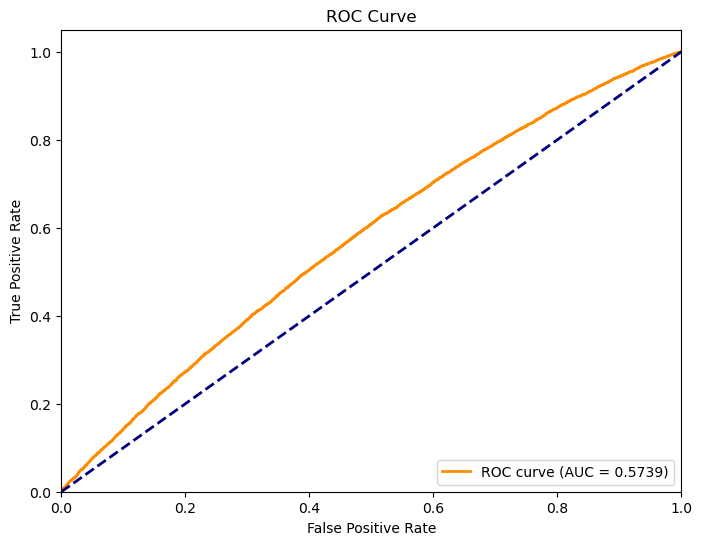

In [21]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc



# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()